# imports and defs

In [10]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy import meshgrid
from geopy.geocoders import Nominatim
import numbers
from tqdm import tqdm
from shapely.geometry  import Point
from shapely.geometry import shape
import geopandas as gpd 

In [11]:
def check_for_nans_infs_zeros(data_sts):
    print('Nans:',np.sum(np.isnan(data_sts)))
    print('Infs:' ,np.sum(np.isinf(data_sts)))
    print('Zeros:',np.sum((data_sts==0)))
    

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [13]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, method=interpolation)
    y_quantiles = np.quantile(y, quantiles, method=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)


In [14]:
def create_mask(fo,lat_obs_cru,lon_obs_cru,buffer=0,plot=0):
  filename=gpd.read_file(fo)
  shp_geom = shape(filename.geometry[0])

  xxc, yyc = meshgrid(lon_obs_cru,lat_obs_cru)
  mask_shape=np.zeros(xxc.shape,dtype=bool)
  if plot==1:
    x,y = shp_geom.exterior.xy
    plt.plot(x,y)
  N1=xxc.shape[0]
  N2=xxc.shape[1]

  for lat_i in range(0,N1):
    for lon_i in range(0,N2):
      xi=xxc[lat_i,lon_i]
      yi=yyc[lat_i,lon_i]
      m1= (shp_geom.contains(Point(xi, yi)) or shp_geom.touches(Point(xi, yi)))
      mask_shape[lat_i,lon_i]=not m1

  return mask_shape

## Import data

In [18]:
output_figname = ''
path_out_IMD = '/home/vikram/BCSD_data/India_P_BCSDd'+output_figname
shape_bound='/home/vikram/BCSD_Shapefiles/ind.shp'
map_bounds=[65, 40, 100, 5]
gcm_list = ['CanESM2','GFDL_CM3','MIROC_ESM','MRI_ESM1','ACCESS1_0','NorESM1_M','CM5A_LR','CNRM_CM5','MPI_ESM_MR']
gcm_name = gcm_list[1]

In [19]:

gcm_meta=np.load(path_out_IMD + '/bcsd_imd_metadata_'+gcm_list[0]+'.npy',allow_pickle=True)
Nyears_train = gcm_meta.item()['Nyears_train']
N_future_start = 2045-2006
st=gcm_meta.item()['st']
en=gcm_meta.item()['en']
lat_obs=gcm_meta.item()['lat_obs']
lon_obs=gcm_meta.item()['lon_obs']
mask=gcm_meta.item()['mask']

N1=lat_obs.shape[0]
N2=lon_obs.shape[0]


In [20]:
mask_nan = np.array(mask , dtype =np.float16)
mask_nan[mask == True] = np.nan
mask_nan[mask == False] = 1

In [23]:
imd_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_obs_imd_pred.npy'))[:]

gcm_meta=np.load(path_out_IMD + '/bcsd_imd_metadata_'+gcm_name+'.npy',allow_pickle=True)
lat_gcm_01=gcm_meta.item()['lat_gcm']
lon_gcm_01=gcm_meta.item()['lon_gcm']
gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_imd_pred.npy'))[:]
data_gf_test=np.zeros(imd_test.shape)
for i in range(gcm_test.shape[0]):
    data_gf_test[i,:,:]=uu.regrid(gcm_test[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)


out_id='pre_'+gcm_name 
bcsd_gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/detrended_BCSD_outputs_historical'+out_id+'.npy'))[:]


j=10
out_id='pre_rnd_new_'+str(j)  
bcsd_rnd_test=uu.correct_nan_inf_neg((np.load(path_out_IMD + '/BCSD_outputs_'+out_id+'.npy')))[:]

    
    
rdn=  np.random.randn(gcm_test.shape[0],gcm_test.shape[1],gcm_test.shape[2])
rdn =np.exp(rdn) 
data_rf_test=np.zeros(imd_test.shape)

for i in range(gcm_test.shape[0]):
    data_rf_test[i,:,:]=uu.regrid(rdn[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
    
    

In [24]:
mask_in_coarse=create_mask(shape_bound,lat_gcm_01,lon_gcm_01,buffer=0,plot=0)

mask_in_coarse_nan = np.array(mask_in_coarse , dtype =np.float16)
mask_in_coarse_nan[mask_in_coarse == True] = np.nan
mask_in_coarse_nan[mask_in_coarse == False] = 1

In [25]:
list(map(np.shape,[bcsd_rnd_test,gcm_test,bcsd_gcm_test,bcsd_rnd_test,rdn]))

[(38325, 33, 35),
 (38325, 19, 16),
 (38325, 33, 35),
 (38325, 33, 35),
 (38325, 19, 16)]

# Plot

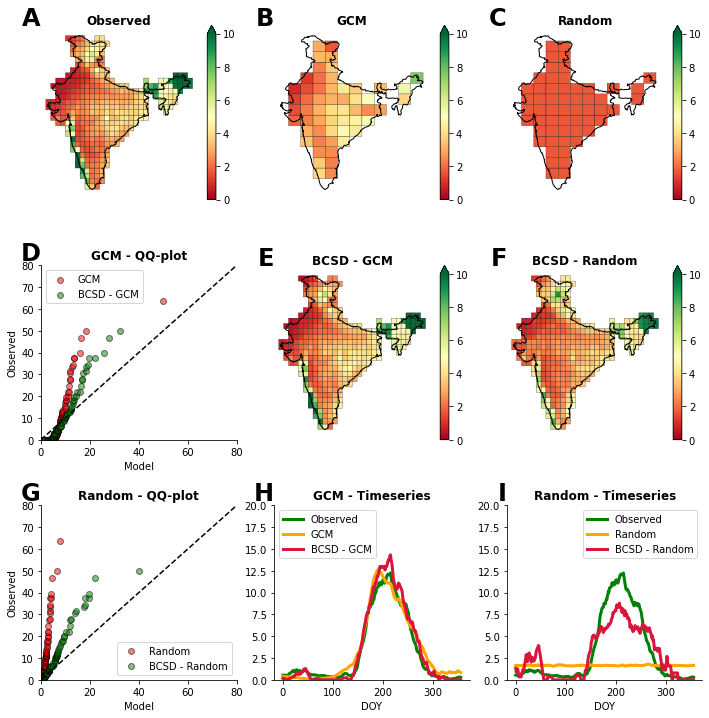

In [32]:
comap = 'RdYlGn'
plt.figure(figsize= (10,10))
ax = plt.subplot(333)
plt.pcolor(lon_gcm_01,lat_gcm_01,rdn.mean(axis=0)*mask_in_coarse_nan,cmap = comap,vmax =10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("Random",fontweight = 'bold')
lxx, lyy = 0,1
plt.text(lxx, lyy, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')

    
    
ax = plt.subplot(332)
plt.pcolor(lon_gcm_01,lat_gcm_01,gcm_test.mean(axis=0)*mask_in_coarse_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("GCM",fontweight = 'bold')
plt.text(lxx, lyy, 'B', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')


ax = plt.subplot(335)
plt.pcolor(lon_obs,lat_obs,bcsd_gcm_test.mean(axis=0)*mask_nan,cmap =comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("BCSD - GCM",fontweight = 'bold')
plt.text(lxx, lyy, 'E', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')



ax = plt.subplot(331)
plt.pcolor(lon_obs,lat_obs,imd_test.mean(axis=0)*mask_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("Observed",fontweight = 'bold')
plt.text(lxx, lyy, 'A', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')


ax = plt.subplot(336)
plt.pcolor(lon_obs,lat_obs,bcsd_rnd_test.mean(axis=0)*mask_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("BCSD - Random",fontweight = 'bold')
plt.text(lxx, lyy, 'F', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')



ax = plt.subplot(339)
plt.plot(moving_average(imd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Observed',linewidth = 3 , color = 'g')
plt.plot(moving_average(data_rf_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Random',linewidth = 3, color = 'orange')
plt.plot(moving_average(bcsd_rnd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'BCSD - Random',linewidth = 3, color = 'crimson')
plt.legend()
plt.ylim([0,20])
# plt.xticks([]),plt.yticks([])
plt.xlabel('DOY')
ax.spines[['right', 'top']].set_visible(False)
# plt.axis('off')
plt.title("Random - Timeseries",fontweight = 'bold')
plt.text(lxx, lyy, 'I', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')


ax = plt.subplot(338)
plt.plot(moving_average(imd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Observed',linewidth = 3, color = 'g')
plt.plot(moving_average(data_gf_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'GCM',linewidth = 3, color = 'orange')
plt.plot(moving_average(bcsd_gcm_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'BCSD - GCM',linewidth = 3, color = 'crimson')
plt.ylim([0,20])
# plt.xticks([]),plt.yticks([])

plt.legend()
# plt.axis('off')
plt.title("GCM - Timeseries",fontweight = 'bold')
plt.xlabel('DOY')
ax.spines[['right', 'top']].set_visible(False)
plt.text(lxx, lyy, 'H', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')



ax = plt.subplot(334)

data_x= data_gf_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_obs = imd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_bc = bcsd_gcm_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
qqplot(data_x,data_obs, c='r', alpha=0.5, edgecolor='k',ax=ax)
qqplot(data_bc,data_obs,  c='g', alpha=0.5, edgecolor='k',ax=ax)
plt.ylim([0,80])
plt.xlim([0,80])
plt.xlabel('Model')
plt.ylabel('Observed')
plt.legend(['GCM','BCSD - GCM'])
plt.plot([0,80],[0,80],'k--')
plt.title("GCM - QQ-plot",fontweight = 'bold')
# plt.xticks([]),plt.yticks([])
ax.spines[['right', 'top']].set_visible(False)
plt.text(lxx, lyy, 'D', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')



ax = plt.subplot(337)
data_x= data_rf_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_obs = imd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_bc = bcsd_rnd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
qqplot(data_x,data_obs, c='r', alpha=0.5, edgecolor='k',ax=ax)
qqplot(data_bc,data_obs,  c='g', alpha=0.5, edgecolor='k',ax=ax)
plt.ylim([0,80])
plt.xlim([0,80])
plt.xlabel('Model')
plt.ylabel('Observed')
plt.legend(['Random','BCSD - Random'])
plt.plot([0,80],[0,80],'k--')

plt.title("Random - QQ-plot",fontweight = 'bold')

# plt.xticks([]),plt.yticks([])
ax.spines[['right', 'top']].set_visible(False)
plt.text(lxx, lyy, 'G', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=24,color='k')

plt.tight_layout()
# plt.savefig('./Figure_0_outs/part_a.svg')
plt.savefig('./Figure_1_prec_parametric.png',facecolor= 'w')


# others

In [ ]:

comap = 'RdYlGn'
plt.figure(figsize= (10,10))
ax = plt.subplot(333)
plt.pcolor(lon_gcm_01,lat_gcm_01,rdn.mean(axis=0)*mask_in_coarse_nan,cmap = comap,vmax =10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("Random",fontweight = 'bold')

ax = plt.subplot(332)
plt.pcolor(lon_gcm_01,lat_gcm_01,gcm_test.mean(axis=0)*mask_in_coarse_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("GCM",fontweight = 'bold')

ax = plt.subplot(335)
plt.pcolor(lon_obs,lat_obs,bcsd_gcm_test.mean(axis=0)*mask_nan,cmap =comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("BCSD - GCM",fontweight = 'bold')


ax = plt.subplot(331)
plt.pcolor(lon_obs,lat_obs,imd_test.mean(axis=0)*mask_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("Observed",fontweight = 'bold')


ax = plt.subplot(336)
plt.pcolor(lon_obs,lat_obs,bcsd_rnd_test.mean(axis=0)*mask_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("BCSD - Random",fontweight = 'bold')



ax = plt.subplot(339)
plt.plot(moving_average(imd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Observed',linewidth = 3 , color = 'g')
plt.plot(moving_average(data_rf_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Random',linewidth = 3, color = 'orange')
plt.plot(moving_average(bcsd_rnd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'BCSD - Random',linewidth = 3, color = 'crimson')
plt.legend()
plt.ylim([0,20])
plt.xticks([]),plt.yticks([])
plt.xlabel('DOY')
ax.spines[['right', 'top']].set_visible(False)
# plt.axis('off')
plt.title("Random - Timeseries",fontweight = 'bold')


ax = plt.subplot(338)
plt.plot(moving_average(imd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Observed',linewidth = 3, color = 'g')
plt.plot(moving_average(data_gf_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'GCM',linewidth = 3, color = 'orange')
plt.plot(moving_average(bcsd_gcm_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'BCSD - GCM',linewidth = 3, color = 'crimson')
plt.ylim([0,20])
plt.xticks([]),plt.yticks([])

plt.legend()
# plt.axis('off')
plt.title("GCM - Timeseries",fontweight = 'bold')
plt.xlabel('DOY')
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(334)

data_x= data_gf_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_obs = imd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_bc = bcsd_gcm_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
qqplot(data_x,data_obs, c='r', alpha=0.5, edgecolor='k',ax=ax)
qqplot(data_bc,data_obs,  c='g', alpha=0.5, edgecolor='k',ax=ax)
plt.ylim([0,80])
plt.xlim([0,80])
plt.xlabel('Model')
plt.ylabel('Observed')
plt.legend(['GCM','BCSD - GCM'])
plt.plot([0,80],[0,80],'k--')
plt.title("GCM - QQ-plot",fontweight = 'bold')
plt.xticks([]),plt.yticks([])
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(337)
data_x= data_rf_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_obs = imd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_bc = bcsd_rnd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
qqplot(data_x,data_obs, c='r', alpha=0.5, edgecolor='k',ax=ax)
qqplot(data_bc,data_obs,  c='g', alpha=0.5, edgecolor='k',ax=ax)
plt.ylim([0,80])
plt.xlim([0,80])
plt.xlabel('Model')
plt.ylabel('Observed')
plt.legend(['Random','BCSD - Random'])
plt.plot([0,80],[0,80],'k--')

plt.title("Random - QQ-plot",fontweight = 'bold')

plt.xticks([]),plt.yticks([])
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
# plt.savefig('./Figure_0_outs/part_a.svg')
# plt.savefig('./Figure_0_outs/Figure_ver1.png',facecolor= 'w')


In [ ]:
comap = 'RdYlGn'
plt.figure(figsize= (10,10))
ax = plt.subplot(333)
plt.pcolor(lon_gcm_01,lat_gcm_01,rdn.mean(axis=0)*mask_in_coarse_nan,cmap = comap,vmax =10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("Random",fontweight = 'bold')

ax = plt.subplot(332)
plt.pcolor(lon_gcm_01,lat_gcm_01,gcm_test.mean(axis=0)*mask_in_coarse_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("GCM",fontweight = 'bold')

ax = plt.subplot(335)
plt.pcolor(lon_obs,lat_obs,bcsd_gcm_test.mean(axis=0)*mask_nan,cmap =comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("BCSD - GCM",fontweight = 'bold')


ax = plt.subplot(331)
plt.pcolor(lon_obs,lat_obs,imd_test.mean(axis=0)*mask_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("Observed",fontweight = 'bold')


ax = plt.subplot(336)
plt.pcolor(lon_obs,lat_obs,bcsd_rnd_test.mean(axis=0)*mask_nan,cmap = comap,vmax = 10,vmin=0,edgecolor='k')
shp_ind = gpd.read_file(shape_bound)
shp_ind.plot(fc = 'none',ax=ax)
# plt.colorbar(extend= 'max')
plt.axis('off')
plt.xlim([67,99])
plt.ylim([7,38])
plt.title("BCSD - Random",fontweight = 'bold')



ax = plt.subplot(339)
plt.plot(moving_average(imd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Observed',linewidth = 3 , color = 'g')
plt.plot(moving_average(data_rf_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Random',linewidth = 3, color = 'orange')
plt.plot(moving_average(bcsd_rnd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'BCSD - Random',linewidth = 3, color = 'crimson')
plt.legend()
plt.ylim([0,20])
plt.xticks([]),plt.yticks([])
plt.xlabel('DOY')
ax.spines[['right', 'top']].set_visible(False)
# plt.axis('off')
plt.title("Random - Timeseries",fontweight = 'bold')


ax = plt.subplot(338)
plt.plot(moving_average(imd_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'Observed',linewidth = 3, color = 'g')
plt.plot(moving_average(data_gf_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'GCM',linewidth = 3, color = 'orange')
plt.plot(moving_average(bcsd_gcm_test.reshape((365,-1,33,35),order='F').mean(axis=1)[:,17,17],10), label = 'BCSD - GCM',linewidth = 3, color = 'crimson')
plt.ylim([0,20])
plt.xticks([]),plt.yticks([])

plt.legend()
# plt.axis('off')
plt.title("GCM - Timeseries",fontweight = 'bold')
plt.xlabel('DOY')
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(334)

data_x= data_gf_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_obs = imd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_bc = bcsd_gcm_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
qqplot(data_x,data_obs, c='r', alpha=0.5, edgecolor='k',ax=ax)
qqplot(data_bc,data_obs,  c='g', alpha=0.5, edgecolor='k',ax=ax)
plt.ylim([0,80])
plt.xlim([0,80])
plt.xlabel('Model')
plt.ylabel('Observed')
plt.legend(['GCM','BCSD - GCM'])
plt.plot([0,80],[0,80],'k--')
plt.title("GCM - QQ-plot",fontweight = 'bold')
plt.xticks([]),plt.yticks([])
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(337)
data_x= data_rf_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_obs = imd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
data_bc = bcsd_rnd_test.reshape((365,-1,33,35),order='F')[250,:,17,17]
qqplot(data_x,data_obs, c='r', alpha=0.5, edgecolor='k',ax=ax)
qqplot(data_bc,data_obs,  c='g', alpha=0.5, edgecolor='k',ax=ax)
plt.ylim([0,80])
plt.xlim([0,80])
plt.xlabel('Model')
plt.ylabel('Observed')
plt.legend(['Random','BCSD - Random'])
plt.plot([0,80],[0,80],'k--')

plt.title("Random - QQ-plot",fontweight = 'bold')

plt.xticks([]),plt.yticks([])
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('./Figure_0_outs/part_a.svg')
plt.savefig('./Figure_0_outs/Figure_ver1.png',facecolor= 'w')
